## Import

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

sys.path.append("../src")
import segment

In [2]:
df = pd.read_excel("../data/raw/uk-online-retail.xlsx")

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df['Country'].value_counts(normalize=True)
df = df.loc[(df['Country'] == "United Kingdom") & (df['Quantity'] > 0)]
df.dropna(subset=['CustomerID'], axis=0, inplace=True)

In [5]:
df['InvoiceDate'] = pd.to_datetime(df["InvoiceDate"])
df['Date'] = df['InvoiceDate'].dt.date
df['Revenue'] = df['UnitPrice']*df['Quantity']

## RFM

In [6]:
# Calculate 1-year date range from latest data
earliest_date = df['Date'].min()
end_date = df['Date'].max()

print("Actual Start Date: {}, Actual End Date: {}".format(earliest_date, end_date))

# Filter 1-year data range from original df
start_date = end_date - pd.to_timedelta(364, unit='d')
df_rfm = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

print("RFM Start Date: {}, RFM End Date: {}".format(
    df_rfm['Date'].min(), df_rfm['Date'].max()))

snapshot_date = end_date + dt.timedelta(days=1)
df_rfm.head()

Actual Start Date: 2010-12-01, Actual End Date: 2011-12-09
RFM Start Date: 2010-12-10, RFM End Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Revenue
22523,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10 09:33:00,1.25,15805.0,United Kingdom,2010-12-10,15.0
22524,538172,79321,CHILLI LIGHTS,8,2010-12-10 09:33:00,4.95,15805.0,United Kingdom,2010-12-10,39.6
22525,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10 09:33:00,2.55,15805.0,United Kingdom,2010-12-10,30.6
22526,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10 09:33:00,2.95,15805.0,United Kingdom,2010-12-10,35.4
22527,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10 09:33:00,0.55,15805.0,United Kingdom,2010-12-10,13.2


In [7]:
def get_recency(arr):
    return (snapshot_date - arr.max()).days

rfm = df_rfm.groupby(['CustomerID']).agg({
    'Date': get_recency,
    'InvoiceNo': 'count',
    'Revenue': 'sum'})

rfm.rename(columns={"Date": 'Recency',
                    "InvoiceNo": "Frequency",
                    "Revenue": "Monetary"}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12747.0,3,96,3837.45
12748.0,1,4226,31718.38
12749.0,4,199,4090.88
12820.0,4,59,942.34


In [8]:
def get_score(df, column):  # higher score better
    if (column == 'Frequency') | (column=='Monetary'):
        quantiles = pd.qcut(df[column], q=4, labels=[1, 2, 3, 4])
    elif column == 'Recency':
        quantiles = pd.qcut(df[column], q=4, labels=[4, 3, 2, 1])
    df = df.assign(name=quantiles.values)
    new_column_name = column + '_q'
    return df.rename(columns={"name": new_column_name})

In [9]:
rfm = get_score(rfm, 'Monetary')
rfm = get_score(rfm, 'Frequency')
rfm = get_score(rfm, 'Recency')

In [10]:
cols = ['Recency_q', 'Frequency_q', 'Monetary_q']
rfm['RFM_Score'] = rfm[cols].sum(axis=1)
rfm['RFM_segment'] = rfm[cols].apply(
    lambda row: ''.join(row.values.astype(str)), axis=1)
rfm.head()

,Recency,Frequency,Monetary,Monetary_q,Frequency_q,Recency_q,RFM_Score,RFM_segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,4,1,1,6,114
12747.0,3,96,3837.45,4,3,4,11,434
12748.0,1,4226,31718.38,4,4,4,12,444
12749.0,4,199,4090.88,4,4,4,12,444
12820.0,4,59,942.34,3,3,4,10,433


In [11]:
scaler = StandardScaler()
rfm = scaler.fit_transform(rfm)
# rfm

# Customer Segmentation

In [12]:
pca = segment.get_pca_model(rfm)
pca_df = segment.reduce_dimension(rfm, pca)
pca_df.head()

,x,y,z
0,-0.869440,6.831611,6.001672
1,2.657103,-0.453263,-0.077721
2,7.968743,11.165373,6.708179
3,3.280447,0.040728,-0.381481
4,2.076748,-1.014918,0.034540


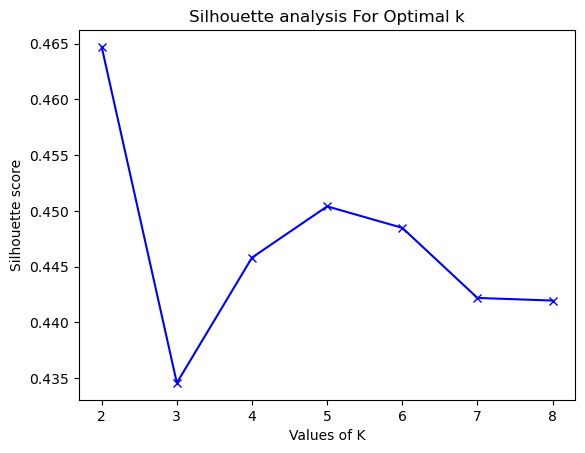

In [13]:
# silhouette score and graph
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(pca_df)
    cluster_labels = kmeans.labels_

# silhouette score
    silhouette_avg.append(segment.get_silhouette_score(pca_df, cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, "bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [14]:
num_clusters = 3 
model = KMeans(n_clusters=num_clusters)
yhat = model.fit_predict(pca_df)

In [15]:
pca_df = segment.insert_clusters_to_df(pca_df, yhat)

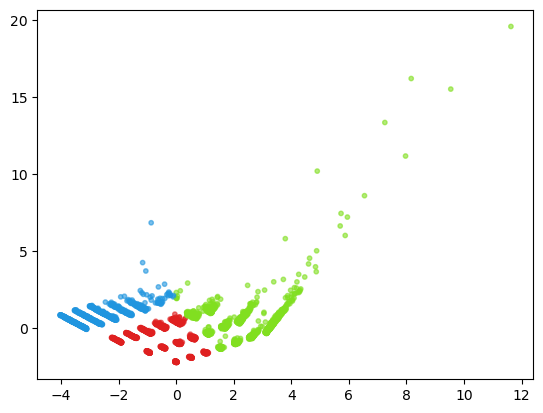

In [16]:
# get centroids
centroids = model.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to df
pca_df['cen_x'] = pca_df.clusters.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
pca_df['cen_y'] = pca_df.clusters.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
pca_df['c'] = pca_df.clusters.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(pca_df['x'], pca_df['y'], c=pca_df.c, alpha = 0.6, s=10)
plt.show()

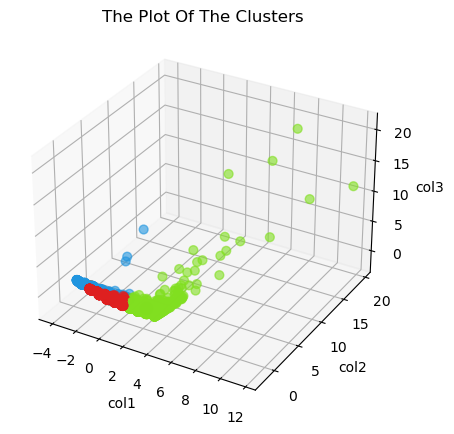

In [17]:
centroids = model.cluster_centers_
segment.plot_clusters(pca_df, yhat, centroids)

In [18]:
pca_df['clusters'].value_counts()

1    1480
0    1422
2     953
Name: clusters, dtype: int64